# Data Science Project: Flight Delay Prediction

## Project Team:

Tomer Yosef                                                                                                                     
Ofek Ben Hamo

### Objective:
This project aims to predict flight delays during takeoff and landing with minute-level precision. The goal is to determine whether there will be a delay and accurately predict the duration of the delay.

### Project Phases:

#### Data Collection: 
Extracting flight information from the FlightRadar website, which provides comprehensive flight data.
#### Data Cleaning:
Processing and cleaning the extracted data to ensure its accuracy and consistency.
#### Feature Engineering:
Adding relevant columns based on the processed information to enhance analysis.
#### Visualization:
Conducting visual exploratory analysis to uncover relationships between database columns.
#### Machine Learning:
Utilizing machine learning algorithms to build predictive models for flight delay estimation.
By following these phases, we aim to provide valuable insights into flight delays and develop accurate prediction models to improve operational efficiency and passenger experience.

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import time
from datetime import datetime
import random
import csv
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr

### part 1 - crawling:
In this part, the information is taken in a process called crawling/scraping,
In all functions, we use the Selenium library for taking the desired information.
General description: We took information from 11 different countries including Israel, the information contains the flights that arrived at the country's airports. For each flight, we go to the page of the country from which it departed.
In addition, go to the page of the flight itself and take the landing/takeoff times that were in the schedule and the actual times
#### 1) Top_search :
this function will receive a URL containing Tel Aviv airport's data, and the function returns the top 10 countries to which the most flights from Israel have departed.
#### 2) scraping_top :
this function will get a URL containing a page of a country, all the flights that have left it in the last few days, and future flights. We pull the information from flights from previous days with a limit up to that day excluding,
so that we can get information about the landing.
After we have received the information and entered it into the data frame, we will go through it and for each flight, we will take the departure destination, concatenate it to the URL appropriately, and send it to the weather_departures function.
#### 3)weather_departures:
this function retrieves weather information from a specified URL, the URL it receives forwards it to the page of the country from which the flight departed and takes the data from the country's weather. and returns them
#### 4) delays :
this function will receive a URL that contains the information for all flights that can match the flight number contained in the URL, the function will find the correct flight, according to the date and time of the flight and will return the take-off and landing times according to the schedule and also the times that actually happened

In [ ]:

def Top_search():
    # Launch the browser and naviglllate to the page
    driver = webdriver.Chrome()
    driver.get("https://www.flightradar24.com/data/airports/tlv")
    # Find the top routes element containing the data
    try:
        top_routes = driver.find_element(By.CSS_SELECTOR, "ul.top-routes")
    except:
        print('Error: Top routes element not found on page.')
        driver.quit()
        exit()
    # Extract the data from the top routes
    routes = []
    airport_codes = [] 
    for route in top_routes.find_elements(By.TAG_NAME, "li"):
        link = route.find_element(By.TAG_NAME, "a")
        name = link.get_attribute("title")
        code = link.text.strip()
        flights_per_week = route.find_element(By.CSS_SELECTOR, "span.pull-right").text.strip()
        routes.append((name, code, flights_per_week))
        airport_codes.append(code)
    driver.quit()
    # Print the DataFrame
    return airport_codes
    # Close the browser

In [ ]:
def weather_departures(url):
    driver = webdriver.Chrome()  # Assuming you have Chrome WebDriver installed
    driver.get(url) 
    try:
        cookies_accept = driver.find_element(By.ID, "onetrust-accept-btn-handler")
        cookies_accept.click()
        time.sleep(2)
    except:
        print("Cookies already accepted or not found")
    try:
        # Wait for the page to load (you can increase the delay if needed)
        time.sleep(5)

        # Find the element containing the temperature
        temperature_element = driver.find_element(By.CSS_SELECTOR, ".weather-value.ng-binding")
        wind_element = driver.find_elements(By.CSS_SELECTOR, ".weather-value.ng-binding")[1]
        direction_element = driver.find_elements(By.CSS_SELECTOR, ".weather-value.ng-binding")[2]

        # Get the text of the elements
        temperature_text = temperature_element.text
        wind_text = wind_element.text
        direction_text = direction_element.text

        # Extract the temperature and wind values
        temperature = temperature_text.split(" ")[0]
        wind = wind_text.split(" ")[0]
        direction = direction_text.split(" ")[0]
    except:
        temperature,wind,direction = None,None,None
    # Close the browser
    driver.quit()
    return temperature,wind,direction


In [ ]:
def scraping_top(url):
    # Launch the browser and navigate to the page
    driver = webdriver.Chrome()
    driver.get(url)
    # Wait for 10 seconds
    time.sleep(10)
    #Click on the cookies button
    try:
        cookies_accept = driver.find_element(By.ID, "onetrust-accept-btn-handler")
        cookies_accept.click()
        time.sleep(2)
    except:
        print("Cookies already accepted or not found")
    #load to the earlier flight
    while True:
        try:
            load_earlier_button = driver.find_element(By.CSS_SELECTOR, "button.btn-flights-load")
            load_earlier_button.click()
            time.sleep(2)  # Wait for the new data to load
        except:
            break 
    # Find the table element containing the data 
    try:
        table = driver.find_element(By.CSS_SELECTOR, "table.table-condensed.table-hover.data-table.m-n-t-15")
    except:
        print('Error: Table element not found on page.')
        driver.quit()
        exit()
    # Extract the data from the table
    data,date,To,temperature_departures,wind_departures,direction_departures = [],[],[],[],[],[]
    # Get all date separators
    date_separators = table.find_elements(By.XPATH, "//tr[contains(@class, 'row-date-separator')]")
    date_index = 0

    for row in table.find_elements(By.TAG_NAME, "tr"):
        day = datetime.now().strftime("%A")
        if "row-date-separator hidden-xs hidden-sm " in row.get_attribute("class") and day in row.text:
            break
        if row in date_separators:
            date_text = row.text.strip()
            date_index += 1

        # Skip the first row that only contains headers
        if "TIME" in row.text:
            continue

        cols = [col.text.strip() for col in row.find_elements(By.TAG_NAME, "td")]
        if len(cols) == 7:  # Make sure there are exactly 7 columns of data
            data.append(cols)
            To.append(airport_name)
            date.append(date_text)
    
    # Convert the data to a pandas DataFrame
    df = pd.DataFrame(data, columns=['TIME', 'FLIGHT', 'FROM', 'AIRLINE', 'AIRCRAFT', '','STATUS'])
    df['DATE'] = date 
    df['TO'] = To
    temperature,wind,direction = weather_departures(url)
    df['TEMPERRATURE_arrival'],df['WIND_arrival'],df['DIRECTION_arrival'] = temperature,wind,direction
    
    driver.quit()
    
    for index, row in df.iterrows():
        value = str(row['FROM']) 
        start_index = value.find("(") + 1
        end_index = value.find(")")
        substring = value[start_index:end_index]
        url = "https://www.flightradar24.com/data/airports/" + substring
        temperature,wind,direction = weather_departures(url)
        temperature_departures.append(temperature)
        wind_departures.append(wind)
        direction_departures.append(direction)
    
    df['TEMPERRATURE_departures'],df['WIND_departures'],df['DIRECTION_departures'] = temperature_departures,wind_departures,direction_departures
    df1 = pd.DataFrame({'Temperature Departures': temperature_departures,'Wind Departures': wind_departures,'Direction Departures': direction_departures})
    df = df.reindex(columns=new_order)
    df1.to_csv('arrivals1.csv', index=False)
    return df

In [ ]:
def wait1():
    time.sleep(200)

def delays(code,date,flight_time):
    # Create a new Chrome web driver
    driver = webdriver.Chrome()
    # Navigate to the web page containing the table
    driver.get("https://www.flightradar24.com/data/flights/" + code)
    #Click on the cookies button
    try:
        cookies_accept = driver.find_element(By.ID, "onetrust-accept-btn-handler")
        cookies_accept.click()
        time.sleep(2)
    except:
        print('Error: cookies element not found on page.')

    scheduled_departures,actual_departures,scheduled_arrival,actual_arrival = None,None,None,None
    list1 = [scheduled_departures,actual_departures,scheduled_arrival,actual_arrival]
    # Find all the rows in the table
    try:
        table = driver.find_element(By.ID, "tbl-datatable")
    except:
        print('Error: Table element not found on page.')
        return list1
        #driver.quit()
        #exit()
    # Loop through each row and check if it matches the search criteria
    
    try:
        for row in table.find_elements(By.TAG_NAME, "tr"):
            # Find the cells in the current row
            cells = row.find_elements(By.TAG_NAME, "td")
            # Debugging: print the length of the cells lis
            if len(cells) >= 2:
                temp = row.text.split(" ")
                row_date = temp[2]+ " " + temp[3] + " "+ temp[4]
                scheduled_departures= temp[-10]
                actual_departures= temp[-9]
                row_time = temp[-8][:5]
                actual_arrival= temp[-7]
                if len(row_time) == 4:
                    row_time = "0" + row_time
            # Check if the date and flight time cells match the search criteria
                if date == row_date:
                    if len(flight_time) == 4:
                        flight_time = "0" + flight_time
                    if flight_time == row_time:
                        list1[0],list1[1],list1[2],list1[3] = scheduled_departures,actual_departures,row_time,actual_arrival
                        break
    except:
        return list1  
             
 # Close the web driver
    driver.quit()
    return list1

In [ ]:
airport_codes = Top_search()
df = scraping_top("https://www.flightradar24.com/data/airports/tlv/arrivals")
df.to_csv('arrivals2.csv', index=False)
i = 0
for code in airport_codes:
    print(i)
    url = "https://www.flightradar24.com/data/airports/" + code + "/arrivals"
    df = scraping_top(url)
    df.to_csv('arrivals2.csv', mode='a', header=False, index=False)
    i += 1
    time.sleep(15+i);
requests_per_minute=500
df = pd.read_csv('arrivals2.csv')
i = 0
for index, row in df.iloc[i:].iterrows():
    if(i == 0):
        scheduled_departures =[]
        actual_departures = []
        scheduled_arrival = []
        actual_arrival = []
    try:
        if(i % 300 == 0 and i > 0):
            wait1()
        code_value = str(row['FLIGHT'])
        print(str(row['FLIGHT']))
        if code_value == 'nan':
            scheduled_departures.append(None)
            actual_departures.append(None)
            scheduled_arrival.append(None)
            actual_arrival.append(None)
            i+=1
            continue
        date_value = str(row['DATE'])
        dt = datetime.strptime(date_value, '%A, %b %d')
        # convert back to string in desired format using strftime()
        dt = dt.replace(year=datetime.now().year)
        date_value = dt.strftime('%d %b %Y')
        flight_time_value = str(row['TIME'])
        list1 = delays(code_value,date_value,flight_time_value)
        scheduled_departures.append(list1[0])
        actual_departures.append(list1[1])
        scheduled_arrival.append(list1[2])
        actual_arrival.append(list1[3])
        i+=1
        print(i)
        time.sleep(60 / requests_per_minute)
    except:
        wait1()
        i+=1
        scheduled_departures.append(None)
        actual_departures.append(None)
        scheduled_arrival.append(None)
        actual_arrival.append(None)
    if(i % 100 == 0):
        data ={}
        df2 = pd.DataFrame(data)
        df2['scheduled_departures'] = scheduled_departures
        df2['actual_departures'] = actual_departures
        df2['scheduled_arrival'] = scheduled_arrival
        df2['actual_arrival'] = actual_arrival
        df2.to_csv('arrivals3.csv')
df['scheduled_departures'] = scheduled_departures
df['actual_departures'] = actual_departures
df['scheduled_arrival'] = scheduled_arrival
df['actual_arrival'] = actual_arrival


### part 2 - data cleaning:
At this stage, we clean up the information we have collected.
In our database we will agree to delete the row in the following cases:
1) In cases where we have an empty cell in the columns -scheduled_departures, FLIGHT, TEMPERRATURE_departures.                   
2) In cases where the character "-" indicates an empty cell in the columns - actual_outputs, temperature_outputs.               
3) In cases where we have the string "calm" and not a number in the column - WIND_departures                                     
4) In cases where we have the string "variable" and not a number in the column - DIRECTION_departures                           
In these cases, we delete the entire row because those columns are needed for each row and we need all those columns without exception. Therefore, if one of the variables does not exist, we will delete the entire row.

In [13]:
#data cleaningS
df = pd.read_csv('arrivals2.csv')
df = df.dropna(subset=['FLIGHT'])
df = df.dropna(subset=['scheduled_departures'])
df = df[df['actual_departures'] != '—']
df = df[(df['TEMPERRATURE_departures'] != '—') & pd.notna(df['TEMPERRATURE_departures'])]
df = df[df['WIND_departures'] != 'Calm']
df = df[df['DIRECTION_departures'] != 'Variable']
df.to_csv('arrivals10.csv', index=False)

### part 3 - Data handling:
In this part, we take the database after cleaning,
We manipulate the information in order to create new columns with data that we can use, we will divide into 3 parts:
1) For all the take-off and landing times we put them in the Database in a string variable,
In order to make a correct conversion, we will have to check if there are cases where the time is between 00 - 10, i.e. a single digit, and in such cases we will add 0 at the beginning of the variable.
For example - 9:50 => 09:50                                                                                                     
2) We will create 4 new columns, 2 for the take off/landing delay and 2 that will contain the words late/early for that flight.
For each row, the function will calculate the take-off/landing delay time.                                                       
If the flight was early, we will put the time as a negative time which will indicate that there was an advance.
3) Finally we will go through all the dataframes and for each column, we will change the -direction_departure,direction_arrival columns to an int variable. which will contain:                                                                                 
1 - late                                                                                                                         
0 - on time                                                                                                                     
(-1) - early 

In [27]:
#returning all the time data to format - HH:MM
# read in the CSV file
df = pd.read_csv('arrivals10.csv')

# add leading zeros to flight numbers with length 4
df['scheduled_departures'] = df['scheduled_departures'].apply(lambda x: str(x).zfill(5) if len(str(x)) == 4 else x)
df['actual_departures'] = df['actual_departures'].apply(lambda x: str(x).zfill(5) if len(str(x)) == 4 else x)
df['scheduled_arrival'] = df['scheduled_arrival'].apply(lambda x: str(x).zfill(5) if len(str(x)) == 4 else x)
df['actual_arrival'] = df['actual_arrival'].apply(lambda x: str(x).zfill(5) if len(str(x)) == 4 else x)
delay_departure_list = []
delay_arrival_list = []
direction_departure =[]
direction_arrival =[]

end_day = datetime.strptime('23:59', '%H:%M')
start_day = datetime.strptime('00:00', '%H:%M')

for index, row in df.iterrows():
    # convert the actual_departures and scheduled_departures columns to datetime objects
    
    # format the datetime objects to strings with hours and minutes only
    actual_departures = datetime.strptime(row['actual_departures'], '%H:%M')
    scheduled_departures = datetime.strptime(row['scheduled_departures'], '%H:%M')
    
    actual_arrival = datetime.strptime(row['actual_arrival'], '%H:%M')
    scheduled_arrival = datetime.strptime(row['scheduled_arrival'], '%H:%M')
    
    actual_departures_hour_int = int(actual_departures.hour)
    scheduled_departures_hour_int = int(scheduled_departures.hour)
    
    temp_departures = actual_departures - scheduled_departures 
    
    if (temp_departures).days < 0:
        if( 20 <= scheduled_departures_hour_int and actual_departures_hour_int <=10):
            actual_departures+= timedelta(minutes=1)
            temp_departures = (end_day - scheduled_departures) + (actual_departures - start_day) 
        else:
            temp_departures = scheduled_departures - actual_departures
            temp_departures = '-' + str(temp_departures)
    elif(20 <= actual_departures_hour_int and scheduled_departures_hour_int <=10):
        scheduled_departures+= timedelta(minutes=1)
        temp_departures = '-' + str((end_day - actual_departures) + (scheduled_departures - start_day))
        
    actual_arrival_hour_int = int(actual_arrival.hour)
    scheduled_arrival_hour_int = int(scheduled_arrival.hour)
    
    temp_arrival = actual_arrival - scheduled_arrival 
    
    if (temp_arrival).days < 0:
        if( 20 <= scheduled_arrival_hour_int and actual_arrival_hour_int <=10):
            actual_arrival+= timedelta(minutes=1)
            temp_arrival = (end_day - scheduled_arrival) + (actual_arrival - start_day) 
        else:
            temp_arrival = '-' + str(scheduled_arrival - actual_arrival)
    elif (20 <= actual_arrival_hour_int and scheduled_arrival_hour_int <=10):
        scheduled_arrival+= timedelta(minutes=1)
        temp_arrival = '-' + str((end_day - actual_arrival) + (scheduled_arrival - start_day))
        
    temp_departures = str(temp_departures)
    temp_arrival = str(temp_arrival)
    
    delay_departure_list.append(temp_departures)
    delay_arrival_list.append(temp_arrival)
    
    # Add a column to indicate whether the difference is positive or negative
    if(temp_departures[0] == '-'):
        direction_departure.append('early')
    else:
        direction_departure.append('late')
    
    if(temp_arrival[0] == '-'):
        direction_arrival.append('early')
    else:
        direction_arrival.append('late')
    

df['delay_departure'] = delay_departure_list
df['direction_departure'] = direction_departure
df['delay_arrival'] = delay_arrival_list
df['direction_arrival'] = direction_arrival
df

,DATE,TIME,FLIGHT,FROM,TO,AIRLINE,AIRCRAFT,STATUS,Unnamed: 8,TEMPERRATURE_departures,...,WIND_arrival,DIRECTION_arrival,scheduled_departures,actual_departures,scheduled_arrival,actual_arrival,delay_departure,direction_departure,delay_arrival,direction_arrival
0,"Tuesday, May 16",12:20,U21265,Basel (BSL),Tel_Aviv,easyJet,A320 (HB-JXO),Landed 12:26,NaN,11.0,...,6,150,07:15,07:20,12:20,12:26,0:05:00,late,0:06:00,late
1,"Tuesday, May 16",12:20,7L218,Baku (GYD),Tel_Aviv,Silk Way West Airlines,B744 (4K-SW888),Landed 20:29,NaN,14.0,...,6,150,10:00,18:37,12:20,20:29,8:37:00,late,8:09:00,late
2,"Tuesday, May 16",12:35,TK862,Istanbul (IST),Tel_Aviv,Turkish Airlines,A320 (TC-JPH),Landed 13:04,NaN,14.0,...,6,150,10:30,11:03,12:35,13:04,0:33:00,late,0:29:00,late
3,"Tuesday, May 16",12:40,GF972,Bahrain (BAH),Tel_Aviv,Gulf Air,A21N (A9C-NC),Landed 12:24,NaN,31.0,...,6,150,09:50,09:50,12:40,12:24,0:00:00,late,-0:16:00,early
4,"Tuesday, May 16",12:50,A3526,Rhodes (RHO),Tel_Aviv,Aegean Airlines,A320 (SX-DVX),Landed 12:43,NaN,19.0,...,6,150,11:20,11:28,12:50,12:43,0:08:00,late,-0:07:00,early
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3642,"Wednesday, May 17",21:00,AC868,Halifax (YHZ),London,Air Canada,B38M (C-FSEQ),Landed 20:40,NaN,10.0,...,6,100,11:00,11:15,21:00,20:40,0:15:00,late,-0:20:00,early
3643,"Wednesday, May 17",21:00,BA607,Pisa (PSA),London,British Airways,A320 (G-EUYO),Landed 22:30,NaN,14.0,...,6,100,19:45,21:33,21:00,22:30,1:48:00,late,1:30:00,late
3644,"Wednesday, May 17",21:00,BA1407,Manchester (MAN),London,British Airways,A21N (G-NEOY),Landed 21:19,NaN,14.0,...,6,100,20:00,20:52,21:00,21:19,0:52:00,late,0:19:00,late
3645,"Wednesday, May 17",21:05,BA821,Copenhagen (CPH),London,Finnair,A320 (OH-LXI),Landed 21:49,NaN,9.0,...,6,100,20:05,21:24,21:05,21:49,1:19:00,late,0:44:00,late


In [28]:
def convert_to_minutes(time_string):
    if isinstance(time_string, str):
        if time_string.startswith('-'):
            time_string = time_string[1:]  # Remove the negative sign
            sign_multiplier = -1
        else:
            sign_multiplier = 1

        time_object = datetime.strptime(time_string, "%H:%M:%S")
        total_minutes = (time_object.hour * 60 + time_object.minute) * sign_multiplier
        return total_minutes

    elif isinstance(time_string, float):
        return None  # or any other appropriate value for non-time floats

    else:
        return None  # or any other appropriate value for non-string and non-float values


df["delay_departure"] = df["delay_departure"].apply(convert_to_minutes)
df["delay_arrival"] = df["delay_arrival"].apply(convert_to_minutes)
df.loc[df['delay_departure'] < 0, 'direction_departure'] = -1
df.loc[df['delay_departure'] > 0, 'direction_departure'] = 1
df.loc[df['delay_departure'] == 0, 'direction_departure'] = 0
df.loc[df['delay_arrival'] < 0, 'direction_arrival'] = -1
df.loc[df['delay_arrival'] > 0, 'direction_arrival'] = 1
df.loc[df['delay_arrival'] == 0, 'direction_arrival'] = 0
# write out the modified DataFrame to a new CSV file
df.to_csv('arrivals10.csv', index=False)
df

,DATE,TIME,FLIGHT,FROM,TO,AIRLINE,AIRCRAFT,STATUS,Unnamed: 8,TEMPERRATURE_departures,...,WIND_arrival,DIRECTION_arrival,scheduled_departures,actual_departures,scheduled_arrival,actual_arrival,delay_departure,direction_departure,delay_arrival,direction_arrival
0,"Tuesday, May 16",12:20,U21265,Basel (BSL),Tel_Aviv,easyJet,A320 (HB-JXO),Landed 12:26,NaN,11.0,...,6,150,07:15,07:20,12:20,12:26,5,1,6,1
1,"Tuesday, May 16",12:20,7L218,Baku (GYD),Tel_Aviv,Silk Way West Airlines,B744 (4K-SW888),Landed 20:29,NaN,14.0,...,6,150,10:00,18:37,12:20,20:29,517,1,489,1
2,"Tuesday, May 16",12:35,TK862,Istanbul (IST),Tel_Aviv,Turkish Airlines,A320 (TC-JPH),Landed 13:04,NaN,14.0,...,6,150,10:30,11:03,12:35,13:04,33,1,29,1
3,"Tuesday, May 16",12:40,GF972,Bahrain (BAH),Tel_Aviv,Gulf Air,A21N (A9C-NC),Landed 12:24,NaN,31.0,...,6,150,09:50,09:50,12:40,12:24,0,0,-16,-1
4,"Tuesday, May 16",12:50,A3526,Rhodes (RHO),Tel_Aviv,Aegean Airlines,A320 (SX-DVX),Landed 12:43,NaN,19.0,...,6,150,11:20,11:28,12:50,12:43,8,1,-7,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3642,"Wednesday, May 17",21:00,AC868,Halifax (YHZ),London,Air Canada,B38M (C-FSEQ),Landed 20:40,NaN,10.0,...,6,100,11:00,11:15,21:00,20:40,15,1,-20,-1
3643,"Wednesday, May 17",21:00,BA607,Pisa (PSA),London,British Airways,A320 (G-EUYO),Landed 22:30,NaN,14.0,...,6,100,19:45,21:33,21:00,22:30,108,1,90,1
3644,"Wednesday, May 17",21:00,BA1407,Manchester (MAN),London,British Airways,A21N (G-NEOY),Landed 21:19,NaN,14.0,...,6,100,20:00,20:52,21:00,21:19,52,1,19,1
3645,"Wednesday, May 17",21:05,BA821,Copenhagen (CPH),London,Finnair,A320 (OH-LXI),Landed 21:49,NaN,9.0,...,6,100,20:05,21:24,21:05,21:49,79,1,44,1


### part 4 -Visualization and EDA:
At this stage, we are visualizing the database for graphs, divided into 3 parts:
1) Visualization of a single variable                                                                                           
2) Visualization of two variables in a two-dimensional graph, correlation, and Poisson's coefficient test in order to check the relationship between the columns                                                                                                 
3) Visualization of several variables

#### 1) Visualization of a single variable:
At this stage, we visualized a single column, which is the flight delay for both arrival and departure.
This columns is the basis of the project so we wanted to test it.
We made 3 types of graphs for her

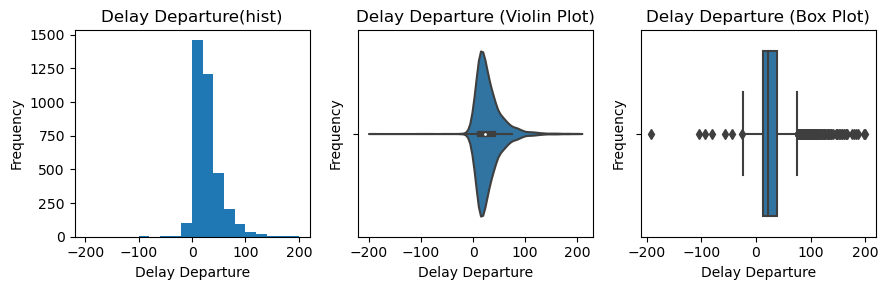

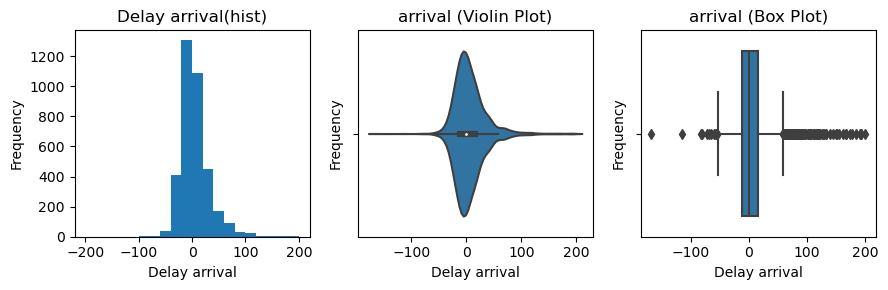

In [66]:
# Load the dataset
data = pd.read_csv('flight_Data.csv')

# Filter the "delay_departure" values within the desired range
filtered_data = data[(data['delay_departure'] >= -200) & (data['delay_departure'] <= 200)]

# Create subplots with a single row and three columns
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# Plot histogram
axs[0].hist(filtered_data['delay_departure'], bins=20, range=(-200, 200))
axs[0].set_xlabel('Delay Departure')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Delay Departure(hist)')

# Plot violin plot
sns.violinplot(x=filtered_data['delay_departure'], ax=axs[1])
axs[1].set_xlabel('Delay Departure')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Delay Departure (Violin Plot)')

# Plot box plot
sns.boxplot(x=filtered_data['delay_departure'], ax=axs[2], whis=1.5)
axs[2].set_xlabel('Delay Departure')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Delay Departure (Box Plot)')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


# Filter the "delay_departure" values within the desired range
filtered_data = data[(data['delay_arrival'] >= -200) & (data['delay_arrival'] <= 200)]

# Create subplots with a single row and three columns
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# Plot histogram
axs[0].hist(filtered_data['delay_arrival'], bins=20, range=(-200, 200))
axs[0].set_xlabel('Delay arrival')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Delay arrival(hist)')

# Plot violin plot
sns.violinplot(x=filtered_data['delay_arrival'], ax=axs[1])
axs[1].set_xlabel('Delay arrival')
axs[1].set_ylabel('Frequency')
axs[1].set_title('arrival (Violin Plot)')

# Plot box plot
sns.boxplot(x=filtered_data['delay_arrival'], ax=axs[2], whis=1.5)
axs[2].set_xlabel('Delay arrival')
axs[2].set_ylabel('Frequency')
axs[2].set_title('arrival (Box Plot)')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


### The code performs three separate analyzes and simulations.
We will take from the 2 columns containing the delay times only the values between 200 and (-200)
minutes because most of the information is there and we want an image with a lot of information, in addition, we created a new column which is a circle that is fed in jumps of 20 so that we have order and not scattered times.


#### 2) Two-dimensional visualization:
The code snippet includes two scatter plots to visualize relationships between variables in your project:                       
1) Scatter Plot: WIND_arrival vs. delay_arrival                                                                                 
* It shows the relationship between the 'WIND_arrival' variable and the 'delay_arrival' variable.                           
* The scatter plot displays data points where the x-axis represents 'WIND_arrival' values and the y-axis represents               'delay_arrival' values.                                                                                                   
* The transparency of the data points is set to 0.5 for better visualization.                                               
* The plot provides insights into any potential correlation or pattern between wind conditions during arrival and the -           corresponding delays.                                                                                                         * The y-axis range is limited to -25 to 150 to focus on the relevant data range.    

2) Scatter Plot: delay_departure vs. WIND_departure                                                                             
* It visualizes the relationship between the 'delay_departure' variable and the 'WIND_departure' variable.                     
* The scatter plot shows the distribution of data points with 'WIND_departure' values on the x-axis and 'delay_departure'          values on the y-axis.                                                                                                        
* Data points are semi-transparent (alpha = 0.5) to aid in visual clarity.                                                       
* This plot helps explore any potential correlation or trend between wind conditions during departure and corresponding           departure delays.                                                                                                                                   

The y-axis range is limited to -25 to 150 to focus on the relevant data range.                                                   
These scatter plots provide concise visual summaries of the relationships between wind conditions and arrival/departure delays in your project. They assist in identifying potential associations or patterns between the variables being analyzed.

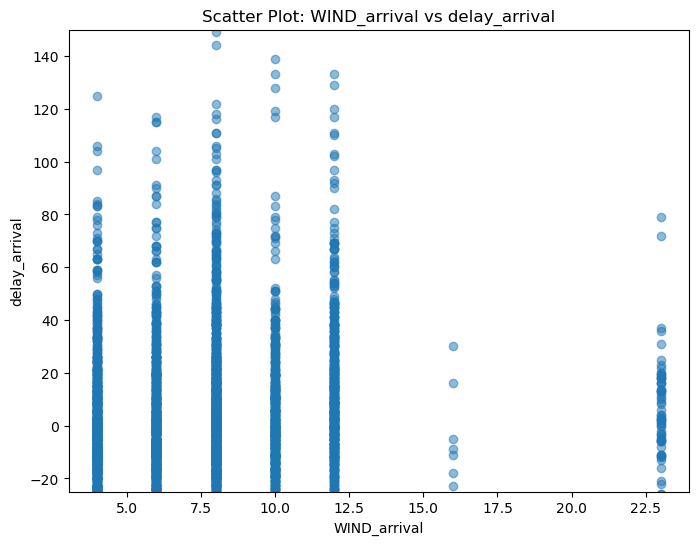

In [132]:
#Two-dimensional visualization

# Select the columns of interest
delay_arrival = data['delay_arrival']
wind_arrival = data['WIND_arrival']

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(wind_arrival,delay_arrival, alpha=0.5)
plt.xlabel('WIND_arrival')
plt.ylabel('delay_arrival')
plt.title('Scatter Plot: WIND_arrival vs delay_arrival')
plt.ylim(-25, 150)
plt.show()

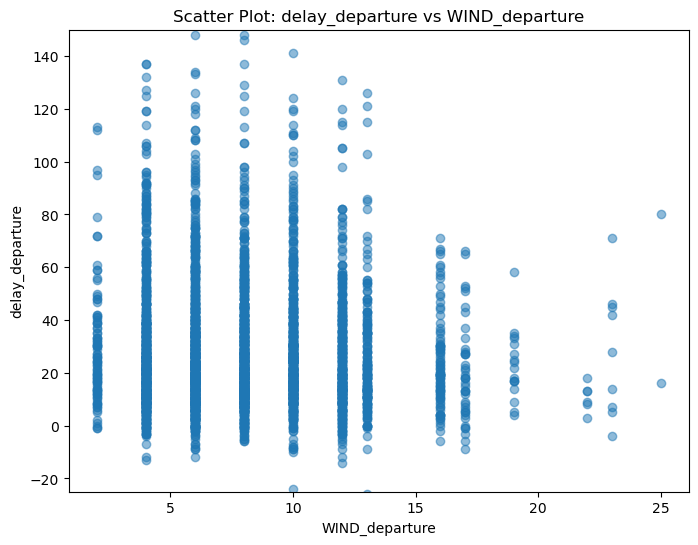

In [130]:

# Select the columns of interest
delay_departure = data['delay_departure']
WIND_departure = data['WIND_departures']

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(WIND_departure,delay_departure, alpha=0.5)
plt.xlabel('WIND_departure')
plt.ylabel('delay_departure')
plt.title('Scatter Plot: delay_departure vs WIND_departure')
plt.ylim(-25, 150)  # Set the x-axis limits

plt.show()

#### Pearson :
The code calculates the Pearson correlation coefficient to measure the linear relationship between variables. 

Specifically, it computes correlations for arrival delays with wind conditions, temperature, and scheduled arrival hour. Similarly, it calculates correlations for departure delays with wind conditions, temperature, and scheduled departure hour. These correlations provide insights into how these variables are related to arrival and departure delays.

In [4]:

# Select the columns of interest
delay_arrival = data['delay_arrival']
wind_arrival = data['WIND_arrival']

# Calculate the Pearson correlation coefficient
corr, _ = pearsonr(wind_arrival, delay_arrival)

print("Pearson Correlation Coefficient between[delay_arrival,WIND_arrival]:", corr)
# Select the columns of interest
delay_arrival = data['delay_arrival']
TEMPERRATURE_arrival = data['TEMPERRATURE_arrival']

# Calculate the Pearson correlation coefficient
corr, _ = pearsonr(TEMPERRATURE_arrival, delay_arrival)

print("Pearson Correlation Coefficient between[delay_arrival,TEMPERRATURE_arrival]:", corr)
# Select the columns of interest
delay_arrival = data['delay_arrival']
scheduled_arrival_hour = data['scheduled_arrival_hour']

# Calculate the Pearson correlation coefficient
corr, _ = pearsonr(scheduled_arrival_hour, delay_arrival)

print("Pearson Correlation Coefficient between[delay_arrival,scheduled_arrival_hour]:", corr)

Pearson Correlation Coefficient between[delay_arrival,WIND_arrival]: 0.08238526629381802
Pearson Correlation Coefficient between[delay_arrival,TEMPERRATURE_arrival]: -0.13180068767218958
Pearson Correlation Coefficient between[delay_arrival,scheduled_arrival_hour]: 0.14290778112405977


In [5]:
# Select the columns of interest
delay_departure = data['delay_departure']
wind_departures = data['WIND_departures']

# Calculate the Pearson correlation coefficient
corr, _ = pearsonr(wind_departures, delay_departure)

print("Pearson Correlation Coefficient between[delay_departure,WIND_departures]:", corr)
# Select the columns of interest
delay_departure = data['delay_departure']
TEMPERRATURE_departures = data['TEMPERRATURE_departures']

# Calculate the Pearson correlation coefficient
corr, _ = pearsonr(TEMPERRATURE_departures, delay_departure)

print("Pearson Correlation Coefficient between[delay_departure,TEMPERRATURE_departures]:", corr)
# Select the columns of interest
delay_arrival = data['delay_arrival']
scheduled_departure_hour = data['scheduled_departure_hour']

# Calculate the Pearson correlation coefficient
corr, _ = pearsonr(scheduled_departure_hour, delay_arrival)

print("Pearson Correlation Coefficient between[delay_arrival,scheduled_departure_hour]:", corr)

Pearson Correlation Coefficient between[delay_departure,WIND_departures]: -0.03778730195145873
Pearson Correlation Coefficient between[delay_departure,TEMPERRATURE_departures]: -0.08051904328972238
Pearson Correlation Coefficient between[delay_arrival,scheduled_departure_hour]: 0.07430303267061733


<b>Correlation Heatmap:
* Variables of interest, including 'delay_departure', 'TEMPERRATURE_departures', and 'scheduled_departure_hour', are selected.
* The correlation matrix is computed to measure the relationships between the variables.
* A heatmap is created to visualize the correlation matrix.
  
<b>The second graph is the same, and is for arrival

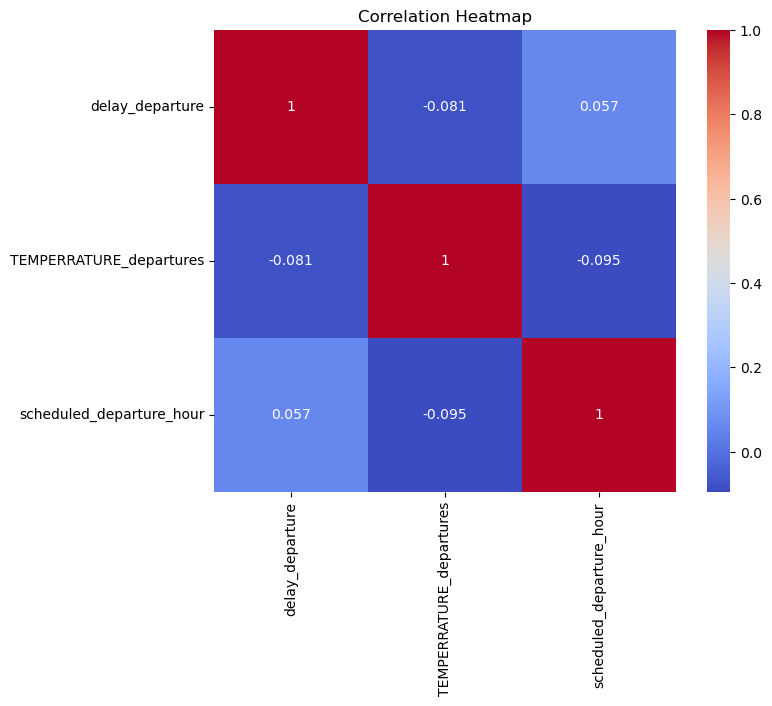

In [3]:

# Select the variables of interest
variables = ['delay_departure', 'TEMPERRATURE_departures', 'scheduled_departure_hour']
selected_data = data[variables]

# Compute the correlation matrix
correlation_matrix = selected_data.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)

# Set the title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

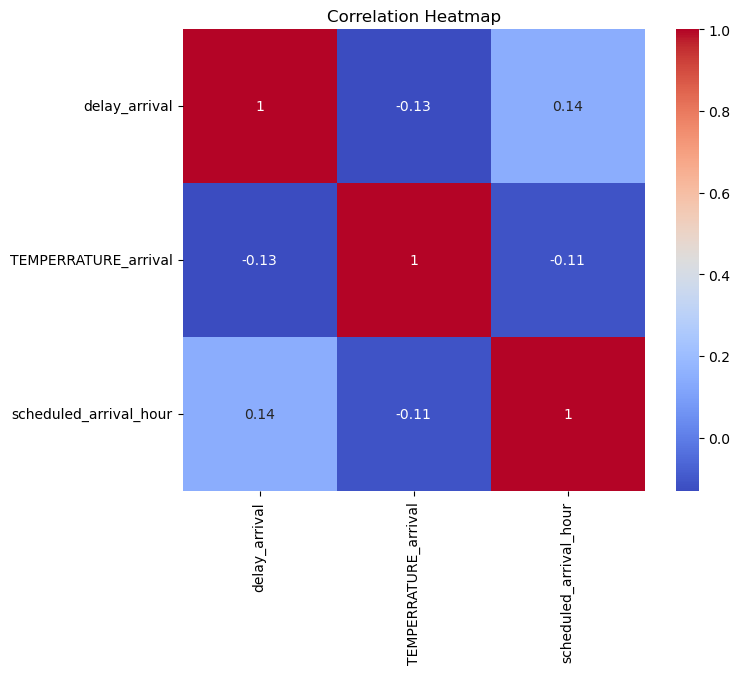

In [4]:

# Select the variables of interest
variables = ['delay_arrival', 'TEMPERRATURE_arrival', 'scheduled_arrival_hour']
selected_data = data[variables]

# Compute the correlation matrix
correlation_matrix = selected_data.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)

# Set the title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

#### 3) Multidimensional visualization:
1) Grouped Bar Plot:

* The data is grouped by the 'delay_departure' column.
* The mean values of selected columns, including 'TEMPERRATURE_departures', 'WIND_departures', and 'scheduled_departure_hour', are calculated.
* A grouped bar plot is created to visualize the average values of the selected columns for each 'delay_departure' group.

2) Another Grouped Bar Plot:

* Similar to the previous section, the data is grouped by the 'delay_arrival' column.
* The mean values of selected columns, including 'TEMPERRATURE_arrival', 'WIND_arrival', and 'scheduled_arrival_hour', are calculated.
* A grouped bar plot is created to visualize the average values of the selected columns for each 'delay_arrival' group.

3) 3D Scatter Plot:

* Variables of interest, including 'delay_departure', 'TEMPERRATURE_departures', and 'scheduled_departure_hour', are selected.
* A 3D scatter plot is created to visualize the relationship between the variables.


4) Another 3D Scatter Plot:

* Similar to the previous 3D scatter plot, this section focuses on 'delay_arrival', 'TEMPERRATURE_arrival', and 'scheduled_arrival_hour' variables.


* Similar to the previous correlation heatmap, this section focuses on 'delay_arrival', 'TEMPERRATURE_arrival', and 'scheduled_arrival_hour' variables.

These visualizations and analyses help understand the relationships and patterns in the data. They can be useful for exploratory data analysis and gaining insights into the dataset.

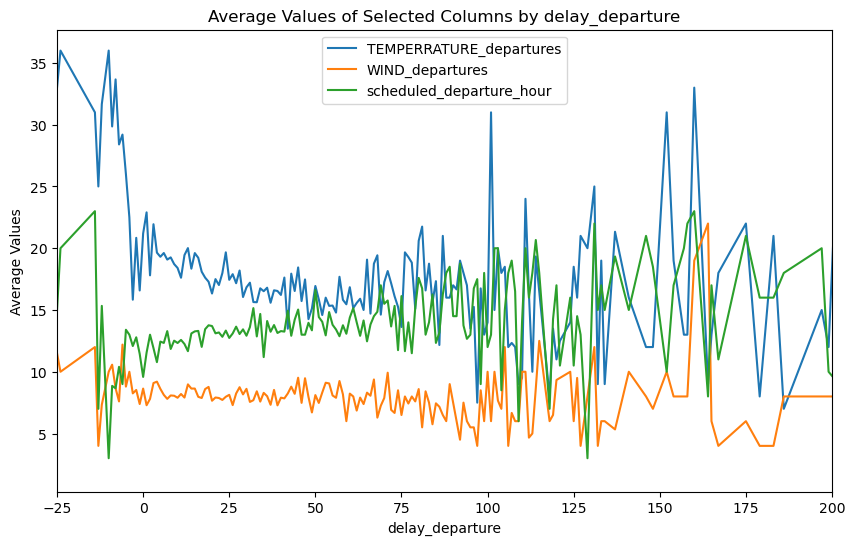

In [159]:
# Group the data by 'delay_departure'
gb = df.groupby(['delay_departure']).mean()[['TEMPERRATURE_departures', 'WIND_departures', 'scheduled_departure_hour']]

# Create the grouped bar plot
ax = gb.plot(figsize=(10, 6))

# Set the labels and title
plt.xlabel('delay_departure')
plt.ylabel('Average Values')
plt.title('Average Values of Selected Columns by delay_departure')

# Set y-axis limit
ax.set_xlim(-25, 200)

# Show the plot
plt.show()



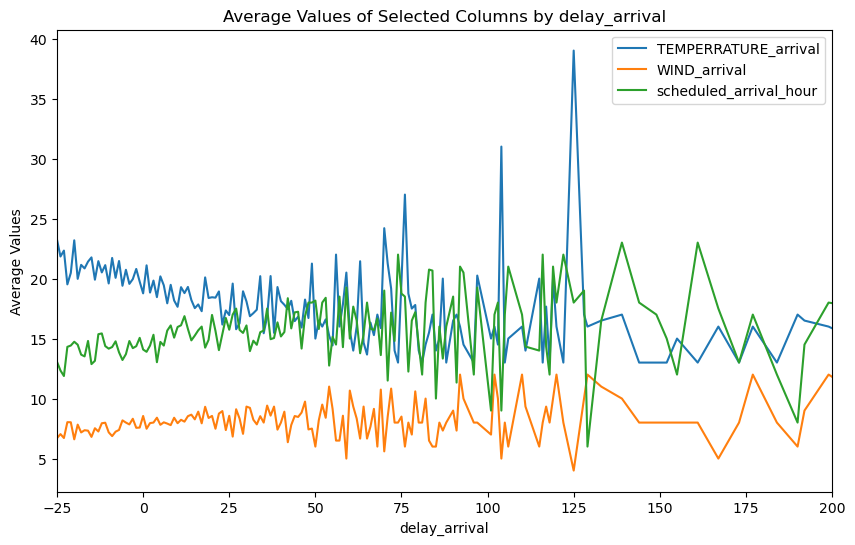

In [161]:
# Group the data by 'delay_departure'
gb = df.groupby(['delay_arrival']).mean()[['TEMPERRATURE_arrival', 'WIND_arrival', 'scheduled_arrival_hour']]

# Create the grouped bar plot
ax = gb.plot(figsize=(10, 6))

# Set the labels and title
plt.xlabel('delay_arrival')
plt.ylabel('Average Values')
plt.title('Average Values of Selected Columns by delay_arrival')

# Set y-axis limit
ax.set_xlim(-25, 200)

# Show the plot
plt.show()


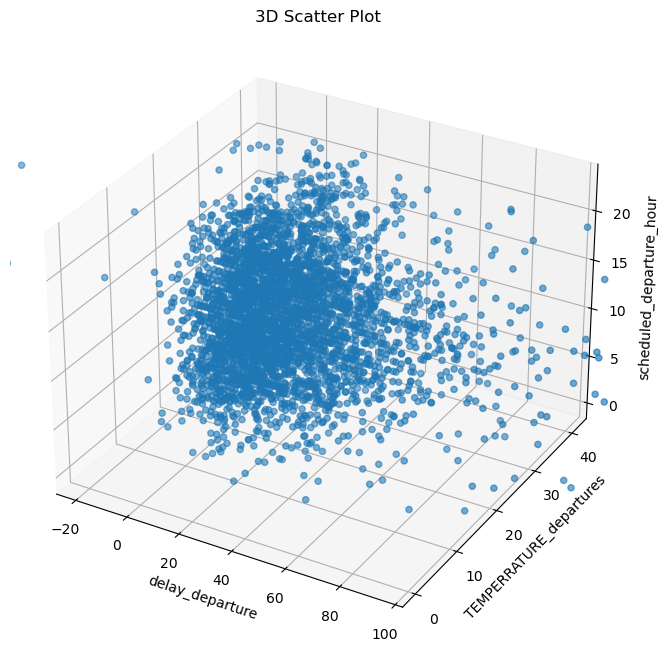

In [5]:
# Select the variables of interest
delay_departure = data['delay_departure']
temperature_departures = data['TEMPERRATURE_departures']
scheduled_departure_hour = data['scheduled_departure_hour']

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(delay_departure, temperature_departures, scheduled_departure_hour)

# Set labels and title
ax.set_xlabel('delay_departure')
ax.set_xlim(-25, 100)
ax.set_ylabel('TEMPERRATURE_departures')

ax.set_zlabel('scheduled_departure_hour')

ax.set_title('3D Scatter Plot')

# Show the plot
plt.show()

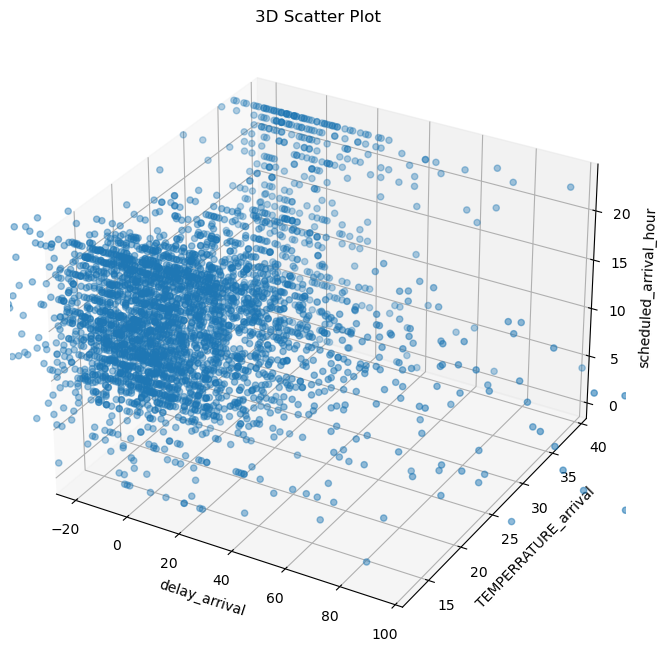

In [7]:

# Select the variables of interest
delay_departure = data['delay_arrival']
temperature_departures = data['TEMPERRATURE_arrival']
scheduled_departure_hour = data['scheduled_arrival_hour']

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(delay_departure, temperature_departures, scheduled_departure_hour)

# Set labels and title
ax.set_xlabel('delay_arrival')
ax.set_xlim(-25, 100)
ax.set_ylabel('TEMPERRATURE_arrival')

ax.set_zlabel('scheduled_arrival_hour')

ax.set_title('3D Scatter Plot')

# Show the plot
plt.show()

## Mechine Learning Proccess
In this part of the process, we aim to find the best model accuracy for predicting delay departure and delay arrival in airline data.

#### For each Model we tried for both Delay Depature and Delay Arrival


### First Try For ['Delay_Depature']: 
(Linear Regression) // Model Accuracy: 0.71831516047533

#### Prepare X and y
We prepare the feature matrix X and the target variable y for the delay departure prediction.

    y = data['delay_departure']
    data = data.drop(['delay_departure'], axis=1)
    X = data.select_dtypes(include=['int', 'float']).values
    
#### Encode the categorical target variable
We encode the categorical target variable y using the label encoder.

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

#### Split the data into training and testing sets
Next, we split the data into training and testing sets for model evaluation.

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

#### Train the machine learning model (Linear Regression)
We train the machine learning model using linear regression.

    model = LinearRegression()
    model.fit(X_train, y_train)
    
#### Evaluate the model
We evaluate the model's accuracy on the testing set.

    accuracy = model.score(X_test, y_test)
    print("Model Accuracy:", accuracy)

The model accuracy for delay departure prediction is 0.71831516047533.
Delay Arrival Model Accuracy: 0.7138775616502793

In [173]:
# Mechine learning arrivalsfinal Delay depatrue Model Accuracy: 0.7138775616502793
# Load the dataset
data = pd.read_csv('arrivals10.csv')

# Prepare X and y
y = data['delay_departure']
data = data.drop(['delay_departure'], axis=1)
X = data.select_dtypes(include=['int', 'float']).values

# Encode the categorical target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train the machine learning model (Linear Regression)
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.71831516047533


<div class="alert alert-block alert-success">
<b>Model Accuracy: 0.71831516047533.</b> The model accuracy for delay arrival prediction using the Linear Regression
</div>

### First Try for ['Delay_Arrival'] : 
(Linear Regression) // Model Accuracy: 0.5865877504910726

#### Prepare X and y
We prepare the feature matrix X and the target variable y for the delay departure prediction.

    y = data['delay_arrival']
    data = data.drop(['delay_arrival'], axis=1)
    X = data.select_dtypes(include=['int', 'float']).values
    
#### Encode the categorical target variable
We encode the categorical target variable y using the label encoder.

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

#### Split the data into training and testing sets
Next, we split the data into training and testing sets for model evaluation.

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

#### Train the machine learning model (Linear Regression)
We train the machine learning model using linear regression.

    model = LinearRegression()
    model.fit(X_train, y_train)
    
#### Evaluate the model
We evaluate the model's accuracy on the testing set.

    accuracy = model.score(X_test, y_test)
    print("Model Accuracy:", accuracy)

The model accuracy for delay Arrival prediction is 0.5865877504910726.
Delay Arrival Model Accuracy: 0.5865877504910726

In [174]:
# Mechine learning arrivalsfinal Delay Arrival Model Accuracy: 0.7138775616502793

# Load the dataset
data = pd.read_csv('arrivals10.csv')

# Prepare X and y
y = data['delay_arrival']
data = data.drop(['delay_arrival'], axis=1)
X = data.select_dtypes(include=['int', 'float']).values

# Encode the categorical target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train the machine learning model (Linear Regression)
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.5865877504910726


<div class="alert alert-block alert-success">
<b>Model Accuracy: 0.5865877504910726.</b> The model accuracy for delay arrival prediction using the Linear Regression
</div>

# ------------------------------------------------------------------------------------------------------
### Second Try for ['Delay_Departure'] : 
(RandomForestRegressor) // Model Accuracy: 0.7793894118341926

#### Prepare X and y
We prepare the feature matrix X and the target variable y for the delay departure prediction.

    y = data['delay_departure']
    data = data.drop(['delay_arrival'], axis=1)
    X = data.select_dtypes(include=['int', 'float']).values
    
#### Encode the categorical target variable
We encode the categorical target variable y using the label encoder.

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

#### Split the data into training and testing sets
Next, we split the data into training and testing sets for model evaluation.

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

#### Train the machine learning model (Random Forest Regressor)
We train the machine learning model using a random forest regressor.

    model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    
#### Evaluate the model
We evaluate the model's accuracy on the testing set.

    accuracy = model.score(X_test, y_test)
    print("Model Accuracy:", accuracy)

The model accuracy for delay departure prediction using the random forest regressor is 0.7765340094843546.


In [11]:
#model = RandomForestRegressor Model Accuracy: 0.7793894118341926

# Load the dataset
data = pd.read_csv('arrivals10.csv')

# Prepare X and y
y = data['delay_departure']
data = data.drop(['delay_departure'], axis=1)
X = data.select_dtypes(include=['int', 'float']).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the machine learning model (Random Forest Regressor)
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print("Model Accuracy:", accuracy)

Model Accuracy:0.7793894118341926


<div class="alert alert-block alert-success">
<b>Model Accuracy: 0.7793894118341926.</b> The model accuracy for delay arrival prediction using the Random Forest Regressor
</div>

### Second Try for ['Delay_Arrival'] : 
(RandomForestRegressor) // Model Accuracy: 0.8436364230025993

#### Prepare X and y
We prepare the feature matrix X and the target variable y for the delay departure prediction.

    y = data['delay_arrival']
    data = data.drop(['delay_arrival'], axis=1)
    X = data.select_dtypes(include=['int', 'float']).values
    
#### Encode the categorical target variable
We encode the categorical target variable y using the label encoder.

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

#### Split the data into training and testing sets
Next, we split the data into training and testing sets for model evaluation.

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

#### Train the machine learning model (Random Forest Regressor)
We train the machine learning model using a random forest regressor.

    model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    
#### Evaluate the model
We evaluate the model's accuracy on the testing set.

    accuracy = model.score(X_test, y_test)
    print("Model Accuracy:", accuracy)

The model accuracy for delay Arrival prediction using the random forest regressor is 0.8436364230025993.

In [12]:
#model = RandomForestRegressor Model Accuracy: 0.7793894118341926

# Load the dataset
data = pd.read_csv('arrivals10.csv')

# Prepare X and y
y = data['delay_arrival']
data = data.drop(['delay_arrival'], axis=1)
X = data.select_dtypes(include=['int', 'float']).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the machine learning model (Random Forest Regressor)
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print("Model Accuracy:", accuracy)

Model Accuracy:0.8436364230025993


<div class="alert alert-block alert-success">
<b>Model Accuracy: 0.8436364230025993.</b> The model accuracy for delay arrival prediction using the Random Forest Regressor
</div>

# ------------------------------------------------------------------------------------------------------
### Third Try for ['Delay_Departure'] : 
(GradientBoostingRegressor) // Model Accuracy: 0.8433379292827841

#### Prepare X and y
We prepare the feature matrix X and the target variable y for the delay departure prediction.

    y = data['delay_departure']
    data = data.drop(['delay_departure', 'actual_departures'], axis=1)
    X = data.select_dtypes(include=['int', 'float']).values
    
#### Split the data into training and testing sets
Next, we split the data into training and testing sets for model evaluation.

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Train the machine learning model (Gradient Boosting Regressor)
We train the machine learning model using a gradient boosting regressor.

    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    
#### Evaluate the model
We evaluate the model's accuracy on the testing set.

    accuracy = model.score(X_test, y_test)
    print("Model Accuracy:", accuracy)

The model accuracy for delay departure prediction using the gradient boosting regressor is 0.8433379292827841.

In [179]:
#model = GradientBoostingRegressor Model Accuracy: 0.8433379292827841

# Load the dataset
data = pd.read_csv('arrivals10.csv')

# Prepare X and y
y = data['delay_departure']
data = data.drop(['delay_departure', 'actual_departures'], axis=1)
X = data.select_dtypes(include=['int', 'float']).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the machine learning model (Gradient Boosting Regressor)
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print("Model Accuracy:", accuracy)


Model Accuracy: 0.8433379292827841


<div class="alert alert-block alert-success">
<b>Model Accuracy: 0.8433379292827841.</b> The model accuracy for delay arrival prediction using the gradient boosting regressor
</div>

### Third Try for ['Delay_Arrival'] : 
(GradientBoostingRegressor) // Model Accuracy: 0.8659596309495732

#### Prepare X and y
We prepare the feature matrix X and the target variable y for the delay arrival prediction.

    y = data['delay_arrival']
    data = data.drop(['delay_arrival', 'actual_arrival'], axis=1)
    X = data.select_dtypes(include=['int', 'float']).values
    
#### Split the data into training and testing sets
Next, we split the data into training and testing sets for model evaluation.

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Train the machine learning model (Gradient Boosting Regressor)
We train the machine learning model using a gradient boosting regressor.

    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    
#### Evaluate the model
We evaluate the model's accuracy on the testing set.

    accuracy = model.score(X_test, y_test)
    print("Model Accuracy:", accuracy)

The model accuracy for delay arrival prediction using the gradient boosting regressor is 0.8659596309495732.

In [13]:
#model = GradientBoostingRegressor Model Accuracy: 0.8659596309495732

# Load the dataset
data = pd.read_csv('arrivals10.csv')

# Prepare X and y
y = data['delay_arrival']
data = data.drop(['delay_arrival', 'actual_arrival'], axis=1)
X = data.select_dtypes(include=['int', 'float']).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the machine learning model (Gradient Boosting Regressor)
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print("Model Accuracy:", accuracy)


Model Accuracy: 0.8659596309495732


<div class="alert alert-block alert-success">
<b> Model Accuracy: 0.8659596309495732.</b> The model accuracy for delay arrival prediction using the gradient boosting regressor
</div>

# ------------------------------------------------------------------------------------------------------
### Final Try - Improving The GradientBoostingRegressor Method for ['Delay_Departure'] : 
Predicting Delay Departure with Feature Importance: Accuracy: 93.551856%

#### Prepare X and y
We prepare the feature matrix X and the target variable y for the delay departure prediction.

    y = data['delay_departure']
    data = data.drop(['delay_departure',
    'actual_departures','scheduled_departures','direction_departure','scheduled_departure_hour'], axis=1)
    X = data.select_dtypes(include=['int', 'float']).values
    col_names = data.select_dtypes(include=['int', 'float']).columns

    
#### Train the machine learning model (Gradient Boosting Regressor)
We train the machine learning model using a gradient boosting regressor.

    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    
#### Make predictions
We make predictions using the trained model.

    y_pred = model.predict(X)
    
#### Create a DataFrame with actual and predicted values
We create a DataFrame to compare the actual and predicted values.

    results_df = pd.DataFrame({'Actual Delay': y, 'Predicted Delay': y_pred})
#### Plot the bar plot
We plot a bar plot to visualize the actual and predicted delay values.

    x = np.arange(len(results_df))
    plt.bar(x, results_df['Actual Delay'], label='Actual Delay')
    plt.bar(x, results_df['Predicted Delay'], label='Predicted Delay')
    plt.xlabel('Instance')
    plt.ylabel('Delay')
    plt.title('Actual vs Predicted Delay')
    plt.ylim(-200, 200)
    plt.legend()
    plt.show()
    
#### Print the accuracy percentage
We calculate the accuracy of the model based on the entire dataset.

    accuracy = model.score(X, y) * 100
    print("Accuracy: {:.6f}%".format(accuracy))
    
#### Get the feature importances
    feature_importances = model.feature_importances_

#### Create a DataFrame with the column names and feature importances
We create a DataFrame to display the feature importances.

    importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})
    
#### Sort the DataFrame by feature importances in descending order
We sort the DataFrame in descending order of feature importances.
    
    importance_df.sort_values(by='Importance', ascending=False, inplace=True)

#### Print the feature importances
We print the feature importances.

    print("Feature importances:")
    print(importance_df)


The model accuracy for delay departure prediction using the gradient boosting regressor with feature importance is 93.551856%. The feature importance ranking is as follows:

   1. delay_arrival: 61.3637%
   1. scheduled_arrival_hour: 10.0462%   
   1. WIND_arrival: 8.5243%   
   1. DIRECTION_departures: 8.4675%   
   1. TEMPERRATURE_arrival: 4.9209%   
   1. WIND_departures: 3.7412%   
   1. TEMPERRATURE_departures: 1.9946%   
   1. direction_arrival: 0.9415%

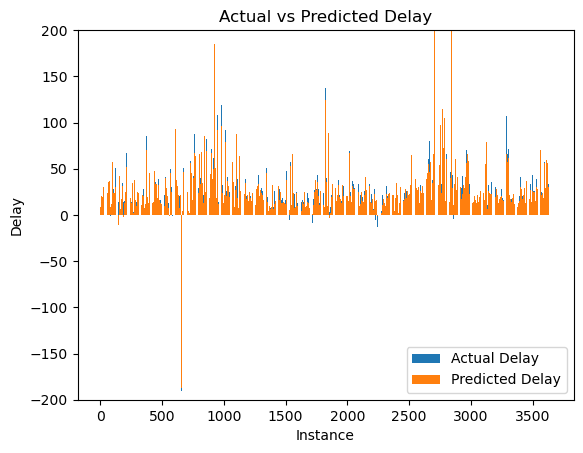

Accuracy: 93.551856%
Feature importances:
                   Feature  Importance
5            delay_arrival    0.613637
7   scheduled_arrival_hour    0.100462
4             WIND_arrival    0.085243
2     DIRECTION_departures    0.084675
3     TEMPERRATURE_arrival    0.049209
1          WIND_departures    0.037412
0  TEMPERRATURE_departures    0.019946
6        direction_arrival    0.009415


In [180]:
#predict with Feature  Importance => Accuracy: 93.551856% ( delay_departure )
# Load the dataset
data = pd.read_csv('arrivals10.csv')

# Prepare X and y
y = data['delay_departure']
data = data.drop(['delay_departure', 'actual_departures','scheduled_departures','direction_departure','scheduled_departure_hour'], axis=1)
X = data.select_dtypes(include=['int', 'float']).values
col_names = data.select_dtypes(include=['int', 'float']).columns

# Train the machine learning model (Gradient Boosting Regressor)
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual Delay': y, 'Predicted Delay': y_pred})

# Create an array for x-axis values (indices)
x = np.arange(len(results_df))

# Plot the bar plot
plt.bar(x, results_df['Actual Delay'], label='Actual Delay')
plt.bar(x, results_df['Predicted Delay'], label='Predicted Delay')
plt.xlabel('Instance')
plt.ylabel('Delay')
plt.title('Actual vs Predicted Delay')
plt.ylim(-200, 200)  # Set the Y-axis limits
plt.legend()
plt.show()

# Print the accuracy percentage
accuracy = model.score(X, y) * 100
print("Accuracy: {:.6f}%".format(accuracy))

# Get the feature importances
feature_importances = model.feature_importances_

# Create a DataFrame with the column names and feature importances
importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

# Sort the DataFrame by feature importances in descending order
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print the feature importances
print("Feature importances:")
print(importance_df)



<div class="alert alert-block alert-success">
<b>feature importance is 93.551856%.</b> The model accuracy for delay arrival prediction using the gradient boosting regressor
</div>

### Final Try - Improving The GradientBoostingRegressor Method for ['Delay_Arrival'] : 
Predicting Delay Arrival with Feature Importance: Accuracy: 94.647679%

#### Prepare X and y
We prepare the feature matrix X and the target variable y for the delay departure prediction.

    y = data['delay_arrival']
    data = data.drop(['delay_arrival', 'actual_arrival','scheduled_arrival','scheduled_arrival_hour',  'TEMPERRATURE_arrival'], axis=1)
    X = data.select_dtypes(include=['int', 'float']).values
    col_names = data.select_dtypes(include=['int', 'float']).columns

    
#### Train the machine learning model (Gradient Boosting Regressor)
We train the machine learning model using a gradient boosting regressor.

    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    
#### Make predictions
We make predictions using the trained model.

    y_pred = model.predict(X)
    
#### Create a DataFrame with actual and predicted values
We create a DataFrame to compare the actual and predicted values.

    results_df = pd.DataFrame({'Actual Delay': y, 'Predicted Delay': y_pred})
    
#### Plot the bar plot
We plot a bar plot to visualize the actual and predicted delay values.

    x = np.arange(len(results_df))
    plt.bar(x, results_df['Actual Delay'], label='Actual Delay')
    plt.bar(x, results_df['Predicted Delay'], label='Predicted Delay')
    plt.xlabel('Instance')
    plt.ylabel('Delay')
    plt.title('Actual vs Predicted Delay')
    plt.ylim(-200, 200)
    plt.legend()
    plt.show()
    
#### Print the accuracy percentage
We calculate the accuracy of the model based on the entire dataset.

    accuracy = model.score(X, y) * 100
    print("Accuracy: {:.6f}%".format(accuracy))
    
#### Get the feature importances
    feature_importances = model.feature_importances_

#### Create a DataFrame with the column names and feature importances
We create a DataFrame to display the feature importances.

    importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})
    
#### Sort the DataFrame by feature importances in descending order
We sort the DataFrame in descending order of feature importances.
    
    importance_df.sort_values(by='Importance', ascending=False, inplace=True)

#### Print the feature importances
We print the feature importances.

    print("Feature importances:")
    print(importance_df)


The model accuracy for delay arrival prediction using the gradient boosting regressor with feature importance is 94.647679%. The feature importance ranking is as follows:

   1. delay_departure: 66.2564%
   1. scheduled_departure_hour: 11.9273%
   1. WIND_arrival: 9.5295%
   1. DIRECTION_arrival: 6.2363%
   1. WIND_departures: 2.7637%
   1. direction_departure: 1.4835%
   1. TEMPERRATURE_departures: 1.0254%
   1. TEMPERRATURE_arrival: 0.7780%

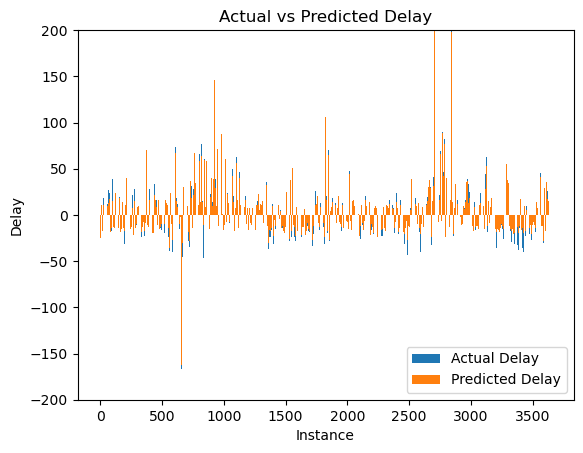

Accuracy: 94.647679%
Feature importances:
                    Feature  Importance
4           delay_departure    0.710512
6         direction_arrival    0.201699
2      DIRECTION_departures    0.037459
7  scheduled_departure_hour    0.016308
3              WIND_arrival    0.016012
0   TEMPERRATURE_departures    0.010078
1           WIND_departures    0.007717
5       direction_departure    0.000216


In [181]:
#predict with Feature  Importance => Accuracy: 93.551856% ( delay_arrival )
# Load the dataset
data = pd.read_csv('arrivals10.csv')

# Prepare X and y
y = data['delay_arrival']
data = data.drop(['delay_arrival', 'actual_arrival','scheduled_arrival','scheduled_arrival_hour', 'TEMPERRATURE_arrival'], axis=1)
X = data.select_dtypes(include=['int', 'float']).values
col_names = data.select_dtypes(include=['int', 'float']).columns

# Train the machine learning model (Gradient Boosting Regressor)
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual Delay': y, 'Predicted Delay': y_pred})

# Create an array for x-axis values (indices)
x = np.arange(len(results_df))

# Plot the bar plot
plt.bar(x, results_df['Actual Delay'], label='Actual Delay')
plt.bar(x, results_df['Predicted Delay'], label='Predicted Delay')
plt.xlabel('Instance')
plt.ylabel('Delay')
plt.title('Actual vs Predicted Delay')
plt.ylim(-200, 200)  # Set the Y-axis limits
plt.legend()
plt.show()

# Print the accuracy percentage
accuracy = model.score(X, y) * 100
print("Accuracy: {:.6f}%".format(accuracy))

# Get the feature importances
feature_importances = model.feature_importances_

# Create a DataFrame with the column names and feature importances
importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

# Sort the DataFrame by feature importances in descending order
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print the feature importances
print("Feature importances:")
print(importance_df)


<div class="alert alert-block alert-success">
<b>feature importance is 94.647679%.</b> The model accuracy for delay arrival prediction using the gradient boosting regressor
</div>